In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
import os

In [ ]:
# note: run ./global flow - run simulation.ipynb to generate these files if they don't exist already

datadir = './global_simulation_files/'

In [3]:
# make grid of azimuth (theta) and elevation (alpha) coordinates
res = 20
    
# full res lattice sampling azimuth and elevation
theta_mat,alpha_mat = np.meshgrid(np.linspace(-np.pi,np.pi,int(res),endpoint=False),
                                np.linspace(-np.pi/2,np.pi/2,int(res/2),endpoint=False))

# flatten matrices
thetas = theta_mat.flatten()
alphas = alpha_mat.flatten()

# remove points where alpha = -pi/2
thetas = thetas[alphas > -np.pi/2]
alphas = alphas[alphas > -np.pi/2]

In [3]:
# function for determining scene depth geometry
def nearness(geometry='sphere',theta=thetas,alpha=alphas,r=1):
    if geometry == 'sphere':
        mu = 1/r*np.ones_like(theta)
    elif geometry == 'floor':
        mu = np.abs(np.sin(alpha))/r * (alpha < 0)
    return mu

# equations slightly modified (signs and axis labels changed) from
# eqn 2.13 and following matrices in
# http://www.cds.caltech.edu/~murray/preprints/humbert05-phd.pdf
def tangentialflow(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,geometry='sphere',theta=thetas,alpha=alphas,r=1,theta0=0,alpha0=0):
    mu = nearness(geometry=geometry,theta=theta,alpha=alpha,r=r)
    flow_horiz = -np.sin(alpha)*np.cos(theta)*Wz + \
                 np.sin(alpha)*np.sin(theta)*Wx + \
                 -np.cos(alpha)*Wy + \
                 mu*(np.sin(theta)*Vz + np.cos(theta)*Vx)
    flow_vert = np.sin(theta)*Wz + \
                np.cos(theta)*Wx + \
                mu*(np.sin(alpha)*np.cos(theta)*Vz + \
                          -np.sin(alpha)*np.sin(theta)*Vx + \
                          np.cos(alpha)*Vy)
    return flow_horiz, flow_vert


In [4]:
# predict velocity from flow with weighted least squares
def getvel(flow,theta=thetas,alpha=alphas,geometry='sphere',DOFs=6,weights=0):
    
    # if no weights were given, assume uniform
    if weights == 0:
        weights=np.ones(len(theta))
        
    vxtemplate = np.ndarray.flatten(np.array(tangentialflow(Vx=1,theta=theta,alpha=alpha,geometry=geometry)))
    vytemplate = np.ndarray.flatten(np.array(tangentialflow(Vy=1,theta=theta,alpha=alpha,geometry=geometry)))
    vztemplate = np.ndarray.flatten(np.array(tangentialflow(Vz=1,theta=theta,alpha=alpha,geometry=geometry)))
    wxtemplate = np.ndarray.flatten(np.array(tangentialflow(Wx=1,theta=theta,alpha=alpha,geometry=geometry)))
    wytemplate = np.ndarray.flatten(np.array(tangentialflow(Wy=1,theta=theta,alpha=alpha,geometry=geometry)))
    wztemplate = np.ndarray.flatten(np.array(tangentialflow(Wz=1,theta=theta,alpha=alpha,geometry=geometry)))
    
    if DOFs == 1:
        templates = vztemplate
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    
    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
    
    # solve for self motion
    pred = np.zeros([6,1])
    pred_DOF,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    
    if DOFs == 1:
        pred[2] = pred_DOF
    elif DOFs == 3:
        pred[0] = pred_DOF[0]  
        pred[2] = pred_DOF[1]  
        pred[4] = pred_DOF[2]  
    elif DOFs == 6:
        pred = pred_DOF
    return np.squeeze(pred)


def anglediff(a,b,deg=True):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

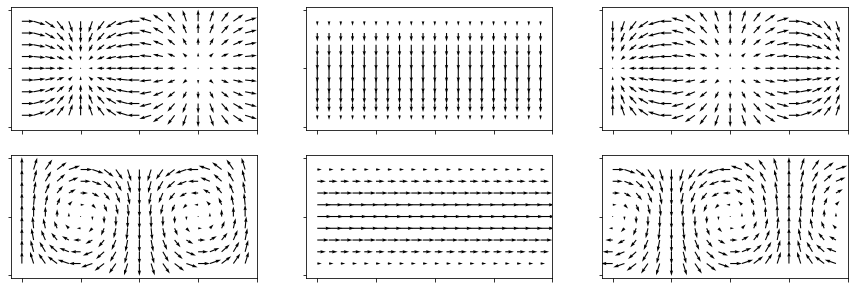

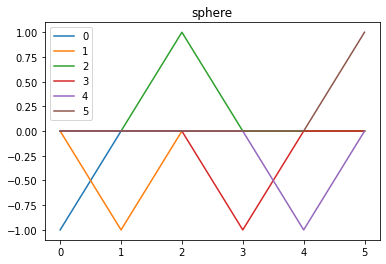

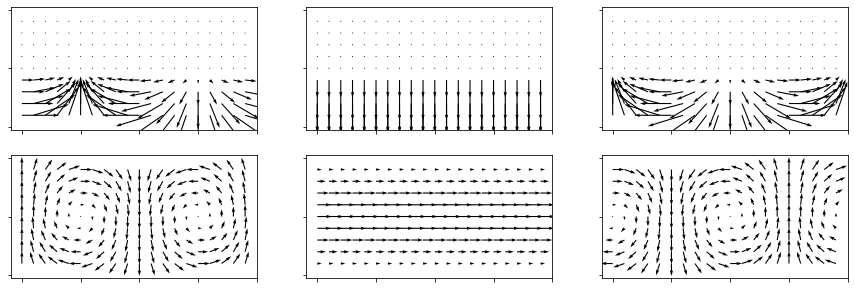

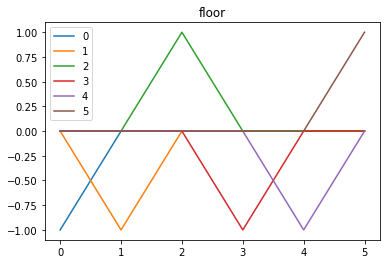

In [5]:
# visualize templates and test flow prediction on noise free unit vectors
for geometry in ['sphere','floor']:
    flows = [tangentialflow(Vx=-1,theta=thetas,alpha=alphas,geometry=geometry), \
            tangentialflow(Vy=-1,theta=thetas,alpha=alphas,geometry=geometry), \
            tangentialflow(Vz=1,theta=thetas,alpha=alphas,geometry=geometry), \
            tangentialflow(Wx=-1,theta=thetas,alpha=alphas,geometry=geometry), \
            tangentialflow(Wy=-1,theta=thetas,alpha=alphas,geometry=geometry), \
            tangentialflow(Wz=1,theta=thetas,alpha=alphas,geometry=geometry)]
    
    plt.figure(figsize=(15,5))
    for f,flow in enumerate(flows):
        plt.subplot(2,3,f+1)
        plt.quiver(thetas,alphas,flow[0],flow[1])
        plt.xlim(-np.pi,np.pi)
        plt.ylim(-np.pi/2 - 0.25,np.pi/2 + 0.25)
        plt.axis('equal')
        plt.yticks([-np.pi/2,0,np.pi/2],[])
        plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[])
        
        if geometry == 'sphere' and f == 5:
            plt.savefig('./global_plots/global_templates.eps', format='eps')
    
    plt.figure()
    for f,flow in enumerate(flows):
        plt.plot(getvel(flow,geometry=geometry),label=f)
    plt.legend()
    plt.title(geometry)

In [6]:
# load and calculate median error, save to file

pctsparses  = [67]
geometries    = ['sphere','floor']
noiselevels   = [0.25]
behavior_DOF_list = [6,3,1]  
spatvarnoises = [1,0]
batch_size = 10000

for pctsparse in pctsparses:

    for geometry in geometries:
        
        for noiselevel in noiselevels:
            
            for behavior_DOF in behavior_DOF_list:
                
                for spatvarnoise in spatvarnoises:

                    file_counter = 0;
                    
                    # we will calculate the median of the errors at each sample location all sims with these parameters
                    median_error_Vx = np.zeros_like(thetas)
                    median_error_Vy = np.zeros_like(thetas)
                    median_error_Vz = np.zeros_like(thetas)
                    median_error_Wx = np.zeros_like(thetas)
                    median_error_Wy = np.zeros_like(thetas)
                    median_error_Wz = np.zeros_like(thetas)
                    median_error_heading = np.zeros_like(thetas)

                    total_repeats = 0;

                    for file in os.listdir(datadir):

                        if spatvarnoise == 0:
                            file_starter = f'global_{pctsparse}pctsparse_{noiselevel}noise_{geometry}_{behavior_DOF}DOFs_{batch_size}batchsize'
                        elif spatvarnoise == 1:
                            file_starter = f'global_{pctsparse}pctsparse_{noiselevel}noise_spatiallyvaryingnoise_{geometry}_{behavior_DOF}DOFs_{batch_size}batchsize'

                        if file.startswith(file_starter):
                            print(file)
                            data = np.load(datadir+file)
                            print("Num repeats = ",data['repeats'])
                            
                            # if this is the first file, initialize outputs, otherwise append
                            if file_counter == 0:
                                
                                # count repeats
                                repeats = data['repeats']
                                total_repeats = total_repeats + data['repeats']
                                
                                tmp_subset_inds = data['all_subset_inds']
                                tmp_err = data['all_err']
                                
                                # only store data for valid recorded repeats (the rest are zeros)
                                all_subset_inds = tmp_subset_inds[0:repeats,:]
                                all_err = tmp_err[0:repeats,:]

                            else:
                                repeats = np.append(repeats,data['repeats'])
                                total_repeats = total_repeats + data['repeats']
                                
                                tmp_subset_inds = data['all_subset_inds']
                                tmp_err = data['all_err']
                                
                                # only store data for valid recorded repeats (the rest are zeros)
                                all_subset_inds = np.concatenate((all_subset_inds,tmp_subset_inds[0:repeats[-1],:]))
                                all_err = np.concatenate((all_err,tmp_err[0:repeats[-1],:]))

                            file_counter += 1;
                            
                    if total_repeats > 0:

                        print("TOTAL repeats = ",total_repeats)
                        
                        # for each location in the visual field:
                        for p in range(np.size(thetas)):

                            # initialize error vector    
                            p_errs_Vx = [];
                            p_errs_Vy = [];
                            p_errs_Vz = [];
                            p_errs_Wx = [];
                            p_errs_Wy = [];
                            p_errs_Wz = [];
                            p_errs_heading = [];

                            # for each repeat    
                            for i in range(total_repeats):

                                # indices used in this repeat and associated error
                                this_subset_inds = np.squeeze(all_subset_inds[i,:])
                                this_subset_err  = all_err[i,:]

                                # if this location was included in this repeat
                                if np.any(this_subset_inds == p):

                                    # append this error to the errors for this location
                                    p_errs_Vx = np.append(p_errs_Vx,this_subset_err[0])
                                    p_errs_Vy = np.append(p_errs_Vy,this_subset_err[1])
                                    p_errs_Vz = np.append(p_errs_Vz,this_subset_err[2])
                                    p_errs_Wx = np.append(p_errs_Wx,this_subset_err[3])
                                    p_errs_Wy = np.append(p_errs_Wy,this_subset_err[4])
                                    p_errs_Wz = np.append(p_errs_Wz,this_subset_err[5])
                                    p_errs_heading = np.append(p_errs_heading,this_subset_err[6])

                            # calculate median and convert to cm/s or deg 
                            median_error_Vx[p] = 100*np.median(p_errs_Vx)
                            median_error_Vy[p] = 100*np.median(p_errs_Vy)
                            median_error_Vz[p] = 100*np.median(p_errs_Vz)
                            median_error_Wx[p] = (180/np.pi)*np.median(p_errs_Wx)
                            median_error_Wy[p] = (180/np.pi)*np.median(p_errs_Wy)
                            median_error_Wz[p] = (180/np.pi)*np.median(p_errs_Wz)
                            median_error_heading[p] = (180/np.pi)*np.median(p_errs_heading)

                            # save it all
                            np.savez(f'./global_median_error_files/{file_starter}_median_errors',median_error_Vz=median_error_Vz,median_error_heading=median_error_heading,median_error_Vx=median_error_Vx,median_error_Vy=median_error_Vy,median_error_Wz=median_error_Wz,median_error_Wy=median_error_Wy,median_error_Wx=median_error_Wx)




global_67pctsparse_0.25noise_sphere_6DOFs_10000batchsize_10000repeats_20220707-123947.npz
Num repeats =  10000
TOTAL repeats =  10000
global_67pctsparse_0.25noise_spatiallyvaryingnoise_sphere_3DOFs_10000batchsize_10000repeats_20220708-164319.npz
Num repeats =  10000
TOTAL repeats =  10000
global_67pctsparse_0.25noise_sphere_3DOFs_10000batchsize_10000repeats_20220707-124305.npz
Num repeats =  10000
TOTAL repeats =  10000
global_67pctsparse_0.25noise_sphere_1DOFs_10000batchsize_10000repeats_20220707-124320.npz
Num repeats =  10000
TOTAL repeats =  10000
global_67pctsparse_0.25noise_floor_3DOFs_10000batchsize_10000repeats_20220707-124903.npz
Num repeats =  10000
TOTAL repeats =  10000


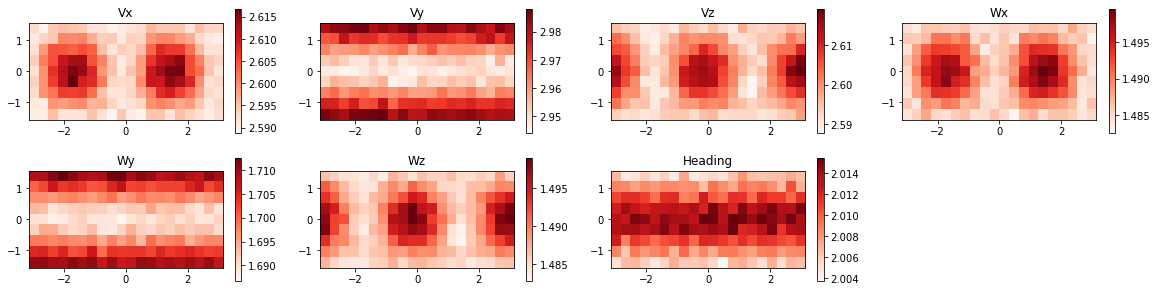

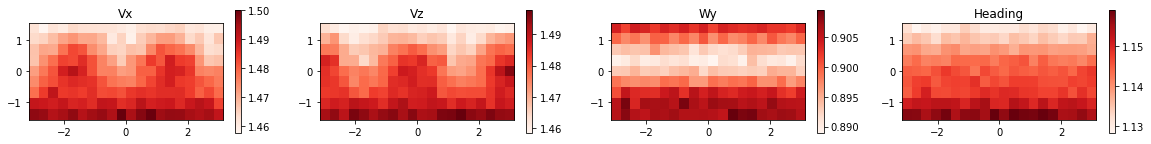

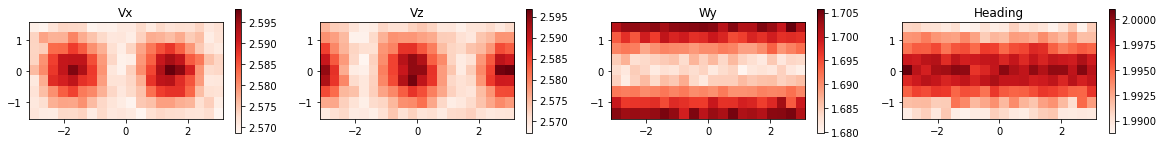

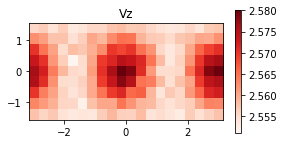

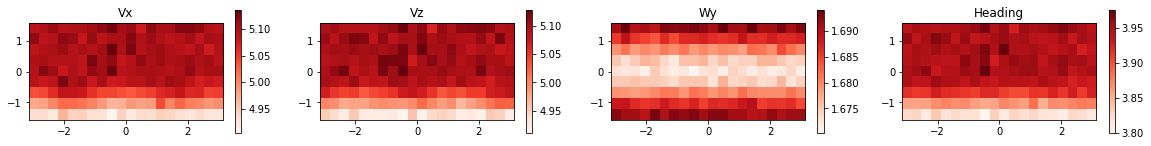

In [14]:
# make rough plots of everything

pctsparses  = [67]
geometries    = ['sphere','floor']
noiselevels   = [0.25]
behavior_DOF_list = [6,3,1]  
spatvarnoises = [1,0]
batch_size = 10000
flip = True

for pctsparse in pctsparses:

    for geometry in geometries:
        
        for noiselevel in noiselevels:
            
            for behavior_DOF in behavior_DOF_list:
                
                for spatvarnoise in spatvarnoises:
                    
                    for file in os.listdir('./global_median_error_files'):

                        if spatvarnoise == 0:
                            file_starter = f'global_{pctsparse}pctsparse_{noiselevel}noise_{geometry}_{behavior_DOF}DOFs_{batch_size}batchsize'
                        elif spatvarnoise == 1:
                            file_starter = f'global_{pctsparse}pctsparse_{noiselevel}noise_spatiallyvaryingnoise_{geometry}_{behavior_DOF}DOFs_{batch_size}batchsize'

                        if file.startswith(file_starter):    
                            
                            data = np.load('./global_median_error_files/'+file)
                            
                            if flip:
                                
                                # flip for imshow because alphas go from negative (lower field) to positive (upper field)
                                median_error_Vx = np.flipud(data['median_error_Vx'])
                                median_error_Vy = np.flipud(data['median_error_Vy'])
                                median_error_Vz = np.flipud(data['median_error_Vz'])
                                median_error_Wx = np.flipud(data['median_error_Wx'])
                                median_error_Wy = np.flipud(data['median_error_Wy'])
                                median_error_Wz = np.flipud(data['median_error_Wz'])
                                median_error_heading = np.flipud(data['median_error_heading'])
                            
                            else:
                                    
                                median_error_Vx = data['median_error_Vx']
                                median_error_Vy = data['median_error_Vy']
                                median_error_Vz = data['median_error_Vz']
                                median_error_Wx = data['median_error_Wx']
                                median_error_Wy = data['median_error_Wy']
                                median_error_Wz = data['median_error_Wz']
                                median_error_heading = data['median_error_heading']
                            
                            # plot all self motion DOFs
                            plt.figure(figsize=(20,5))
                            
                            if behavior_DOF == 6:
                                
                                plt.subplot(2,4,1)
                                plt.title('Vx')
                                heatmap = np.reshape(median_error_Vx,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()
                                
                                plt.subplot(2,4,2)
                                plt.title('Vy')
                                heatmap = np.reshape(median_error_Vy,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()

                                plt.subplot(2,4,3)
                                plt.title('Vz')
                                heatmap = np.reshape(median_error_Vz,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()

                                plt.subplot(2,4,4)
                                plt.title('Wx')
                                heatmap = np.reshape(median_error_Wx,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()

                                plt.subplot(2,4,5)
                                plt.title('Wy')
                                heatmap = np.reshape(median_error_Wy,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()

                                plt.subplot(2,4,6)
                                plt.title('Wz')
                                heatmap = np.reshape(median_error_Wz,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()
                                
                                plt.subplot(2,4,7)
                                plt.title('Heading')
                                heatmap = np.reshape(median_error_heading,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()

                            elif behavior_DOF == 3:
                                
                                plt.subplot(2,4,1)
                                plt.title('Vx')
                                heatmap = np.reshape(median_error_Vx,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()
                                
                                plt.subplot(2,4,2)
                                plt.title('Vz')
                                heatmap = np.reshape(median_error_Vz,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()
                                
                                plt.subplot(2,4,3)
                                plt.title('Wy')
                                heatmap = np.reshape(median_error_Wy,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()
                                
                                plt.subplot(2,4,4)
                                plt.title('Heading')
                                heatmap = np.reshape(median_error_heading,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()
                                
                            elif behavior_DOF == 1:
                                    
                                plt.subplot(2,4,1)
                                plt.title('Vz')
                                heatmap = np.reshape(median_error_Vz,[9,20])
                                plt.imshow(heatmap,cmap='Reds',extent=[-np.pi,np.pi,-np.pi/2,np.pi/2],aspect=1)
                                plt.colorbar()
                                    
                            plt.savefig(f'./global_plots/plot_{file_starter}_All.png', format='png',dpi=300)


In [57]:
def cleanplot(thetas=thetas,alphas=alphas,data_to_plot=0,size=500,logaxis=False,vmin=0,vmax=0):

    ax = plt.axes()
    plt.axis('equal')
    
    if logaxis:
        if vmin!=0 and vmax!=0:
            plt.scatter(np.append(thetas,-thetas[thetas<-3]),np.append(alphas,alphas[thetas<-3]),c=np.append(data_to_plot,data_to_plot[thetas<-3]),cmap='Reds',s=size,norm=colors.LogNorm(vmin=vmin,vmax=vmax))
        else:
            plt.scatter(np.append(thetas,-thetas[thetas<-3]),np.append(alphas,alphas[thetas<-3]),c=np.append(data_to_plot,data_to_plot[thetas<-3]),cmap='Reds',s=size,norm=colors.LogNorm())
    else:
        plt.scatter(np.append(thetas,-thetas[thetas<-3]),np.append(alphas,alphas[thetas<-3]),c=np.append(data_to_plot,data_to_plot[thetas<-3]),cmap='Reds',s=size)

        if vmin!=0 and vmax!=0:
            plt.clim(vmin,vmax)
            
            
    ax.set_facecolor("#ababab")
    ax.set_box_aspect(1/2)

    plt.xlim(-np.pi,np.pi)
    plt.ylim(-np.pi/2,np.pi/2)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    plt.tight_layout()

Vz max cm/s= 2.6191220239311
Vz min cm/s= 2.5878030093522604
Vx max cm/s= 2.6166931429502327
Vx min cm/s= 2.5888109981099685
Vy max cm/s= 2.9880021798842304
Vy min cm/s= 2.9440407058038964
Wx max deg/s= 1.4995409774119524
Wx min deg/s= 1.4825604920101296
Wy max deg/s= 1.7126331149273455
Wy min deg/s= 1.6867050819199072
Wz max deg/s= 1.4990713027792106
Wz min deg/s= 1.4828194709633031


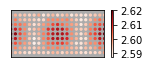

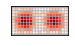

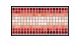

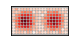

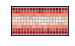

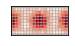

In [58]:
# load and make nice plots of average Vz and heading errors for paper

# FIGURE 1
# SPHERE 6DOF 60 samples, .25 noise

plot_width = 2
plot_height = 1
size = 5

plot_width_small = 1.5
plot_height_small = .75
size_small = 2.5

# big plot of Vz
data = np.load('./global_median_error_files/global_67pctsparse_0.25noise_sphere_6DOFs_10000batchsize_median_errors.npz')

median_error_Vz = data['median_error_Vz']

# max and min for setting colorbar for Vz
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,size=size)
plt.clim(2.587,2.62)

plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_6DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
cbar.set_ticks([2.59, 2.60, 2.61, 2.62])
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_6DOFs_Vz_withcolorbar.png', format='png',dpi=300)

# smaller plots of other dirs on same colorscale
median_error_Vx = data['median_error_Vx']
median_error_Vy = data['median_error_Vy']
median_error_Wx = data['median_error_Wx']
median_error_Wy = data['median_error_Wy']
median_error_Wz = data['median_error_Wz']

# max and min for each little plot to report in caption
print('Vx max cm/s=',np.max(median_error_Vx))
print('Vx min cm/s=',np.min(median_error_Vx))
print('Vy max cm/s=',np.max(median_error_Vy))
print('Vy min cm/s=',np.min(median_error_Vy))
print('Wx max deg/s=',np.max(median_error_Wx))
print('Wx min deg/s=',np.min(median_error_Wx))
print('Wy max deg/s=',np.max(median_error_Wy))
print('Wy min deg/s=',np.min(median_error_Wy))
print('Wz max deg/s=',np.max(median_error_Wz))
print('Wz min deg/s=',np.min(median_error_Wz))

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Vx,size=size_small)
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_6DOFs_Vx.png', format='png',dpi=300)

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Vy,size=size_small)
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_6DOFs_Vy.png', format='png',dpi=300)

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Wx,size=size_small)
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_6DOFs_Wx.png', format='png',dpi=300)

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Wy,size=size_small)
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_6DOFs_Wy.png', format='png',dpi=300)

plt.figure(figsize=(plot_width_small,plot_height_small))
cleanplot(data_to_plot=median_error_Wz,size=size_small)
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_6DOFs_Wz.png', format='png',dpi=300)


Vz max cm/s= 2.5801945801682935
Vz min cm/s= 2.551047531084025
Vz max cm/s= 2.596784674897185
Vz min cm/s= 2.5673009534426807


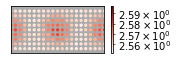

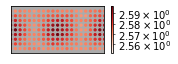

In [65]:
# FIGURE 2 behavior:

plot_width = 2
plot_height = 1
size = 5

do_log = True;
vmin = 2.551
vmax = 2.597

# 1 DOF SPHERE

data = np.load('./global_median_error_files/global_67pctsparse_0.25noise_sphere_1DOFs_10000batchsize_median_errors.npz')
median_error_Vz = data['median_error_Vz']

# Vz

# max and min for setting colorbar for Vz
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,size=size,logaxis=do_log,vmin=vmin,vmax=vmax)
plt.clim(2.551,2.597)

plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_1DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_1DOFs_Vz_withcolorbar.png', format='png',dpi=300)



# 3 DOF SPHERE

data = np.load('./global_median_error_files/global_67pctsparse_0.25noise_sphere_3DOFs_10000batchsize_median_errors.npz')
median_error_Vz = data['median_error_Vz']

# Vz

# max and min for setting colorbar for Vz
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,size=size,logaxis=do_log,vmin=vmin,vmax=vmax)
plt.clim(2.551,2.597)

plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_3DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_sphere_3DOFs_Vz_withcolorbar.png', format='png',dpi=300)



Vz max cm/s= 1.4979023794924635
Vz min cm/s= 1.4584064301369561


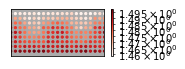

In [63]:
# FIGURE 2 environment

do_log = True;

# 3 DOF SPHERE, spatially varying noise

data = np.load('./global_median_error_files/global_67pctsparse_0.25noise_spatiallyvaryingnoise_sphere_3DOFs_10000batchsize_median_errors.npz')
median_error_Vz = data['median_error_Vz']

# Vz

# max and min for setting colorbar for Vz
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,size=size,logaxis=do_log)

plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_spatiallyvaryingnoise_sphere_3DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_spatiallyvaryingnoise_sphere_3DOFs_Vz_withcolorbar.png', format='png',dpi=300)



Vz max cm/s= 5.127955859003564
Vz min cm/s= 4.910283361551565
Heading max deg= 3.975941191311907
Heading min deg= 3.7991895361343775


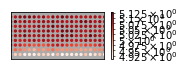

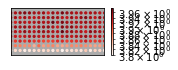

In [64]:
# 3DOF FLOOR -- Vz and heading

do_log = True;

data = np.load('./global_median_error_files/global_67pctsparse_0.25noise_floor_3DOFs_10000batchsize_median_errors.npz')
median_error_Vz = data['median_error_Vz']
median_error_heading = data['median_error_heading']

# Vz

# max and min for setting colorbar for Vz
print('Vz max cm/s=',np.max(median_error_Vz))
print('Vz min cm/s=',np.min(median_error_Vz))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_Vz,size=size,logaxis=do_log)

plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_floor_3DOFs_Vz.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_floor_3DOFs_Vz_withcolorbar.png', format='png',dpi=300)


# Heading
# max and min for setting colorbar for Vz
print('Heading max deg=',np.max(median_error_heading))
print('Heading min deg=',np.min(median_error_heading))

plt.figure(figsize=(plot_width,plot_height))
cleanplot(data_to_plot=median_error_heading,size=size,logaxis=do_log)

plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_floor_3DOFs_heading.png', format='png',dpi=300)

# add colorbar
cbar = plt.colorbar()
plt.savefig(f'./final_plots/final_plot_global_67pctsparse_0.25noise_floor_3DOFs_heading_withcolorbar.png', format='png',dpi=300)
